In [35]:
import matplotlib.pyplot as plt
import pandas as pd
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from sklearn.preprocessing import MinMaxScaler

import foressment_ai as foras
import funcs

### Load and prepare SWAT dataset

##### Load

In [37]:
data_name = 'SWAT'

In [38]:
data = pd.read_csv(f'../datasets/{data_name}.csv')
features_names = list(data.columns)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 51 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   FIT101   40000 non-null  float64
 1   LIT101   40000 non-null  float64
 2   MV101    40000 non-null  int64  
 3   P101     40000 non-null  int64  
 4   P102     40000 non-null  int64  
 5   AIT201   40000 non-null  float64
 6   AIT202   40000 non-null  float64
 7   AIT203   40000 non-null  float64
 8   FIT201   40000 non-null  float64
 9   MV201    40000 non-null  int64  
 10  P201     40000 non-null  int64  
 11  P202     40000 non-null  int64  
 12  P203     40000 non-null  int64  
 13  P204     40000 non-null  int64  
 14  P205     40000 non-null  int64  
 15  P206     40000 non-null  int64  
 16  DPIT301  40000 non-null  float64
 17  FIT301   40000 non-null  float64
 18  LIT301   40000 non-null  float64
 19  MV301    40000 non-null  int64  
 20  MV302    40000 non-null  int64  
 21  MV303    400

In [39]:
data.head()

,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,MV201,...,FIT504,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603
0,2.553246,357.5141,2,2,1,262.625,8.38394,477.8518,2.468971,2,...,0.311693,2,1,252.9159,1.425688,192.0501,0.000128,1,1,1
1,2.532428,357.9459,2,2,1,262.625,8.38394,477.8518,2.468971,2,...,0.311245,2,1,252.6436,1.425688,192.0501,0.000128,1,1,1
2,2.515453,358.3384,2,2,1,262.625,8.38394,477.8518,2.471022,2,...,0.311245,2,1,252.5955,1.425688,191.8258,0.000128,1,1,1
3,2.502002,358.1814,2,2,1,262.625,8.38394,477.8262,2.471791,2,...,0.311245,2,1,252.5154,1.425688,191.7297,0.000128,1,1,1
4,2.487269,358.2992,2,2,1,262.625,8.38394,477.3648,2.471919,2,...,0.311245,2,1,252.5154,1.425688,191.7297,0.000128,1,1,1


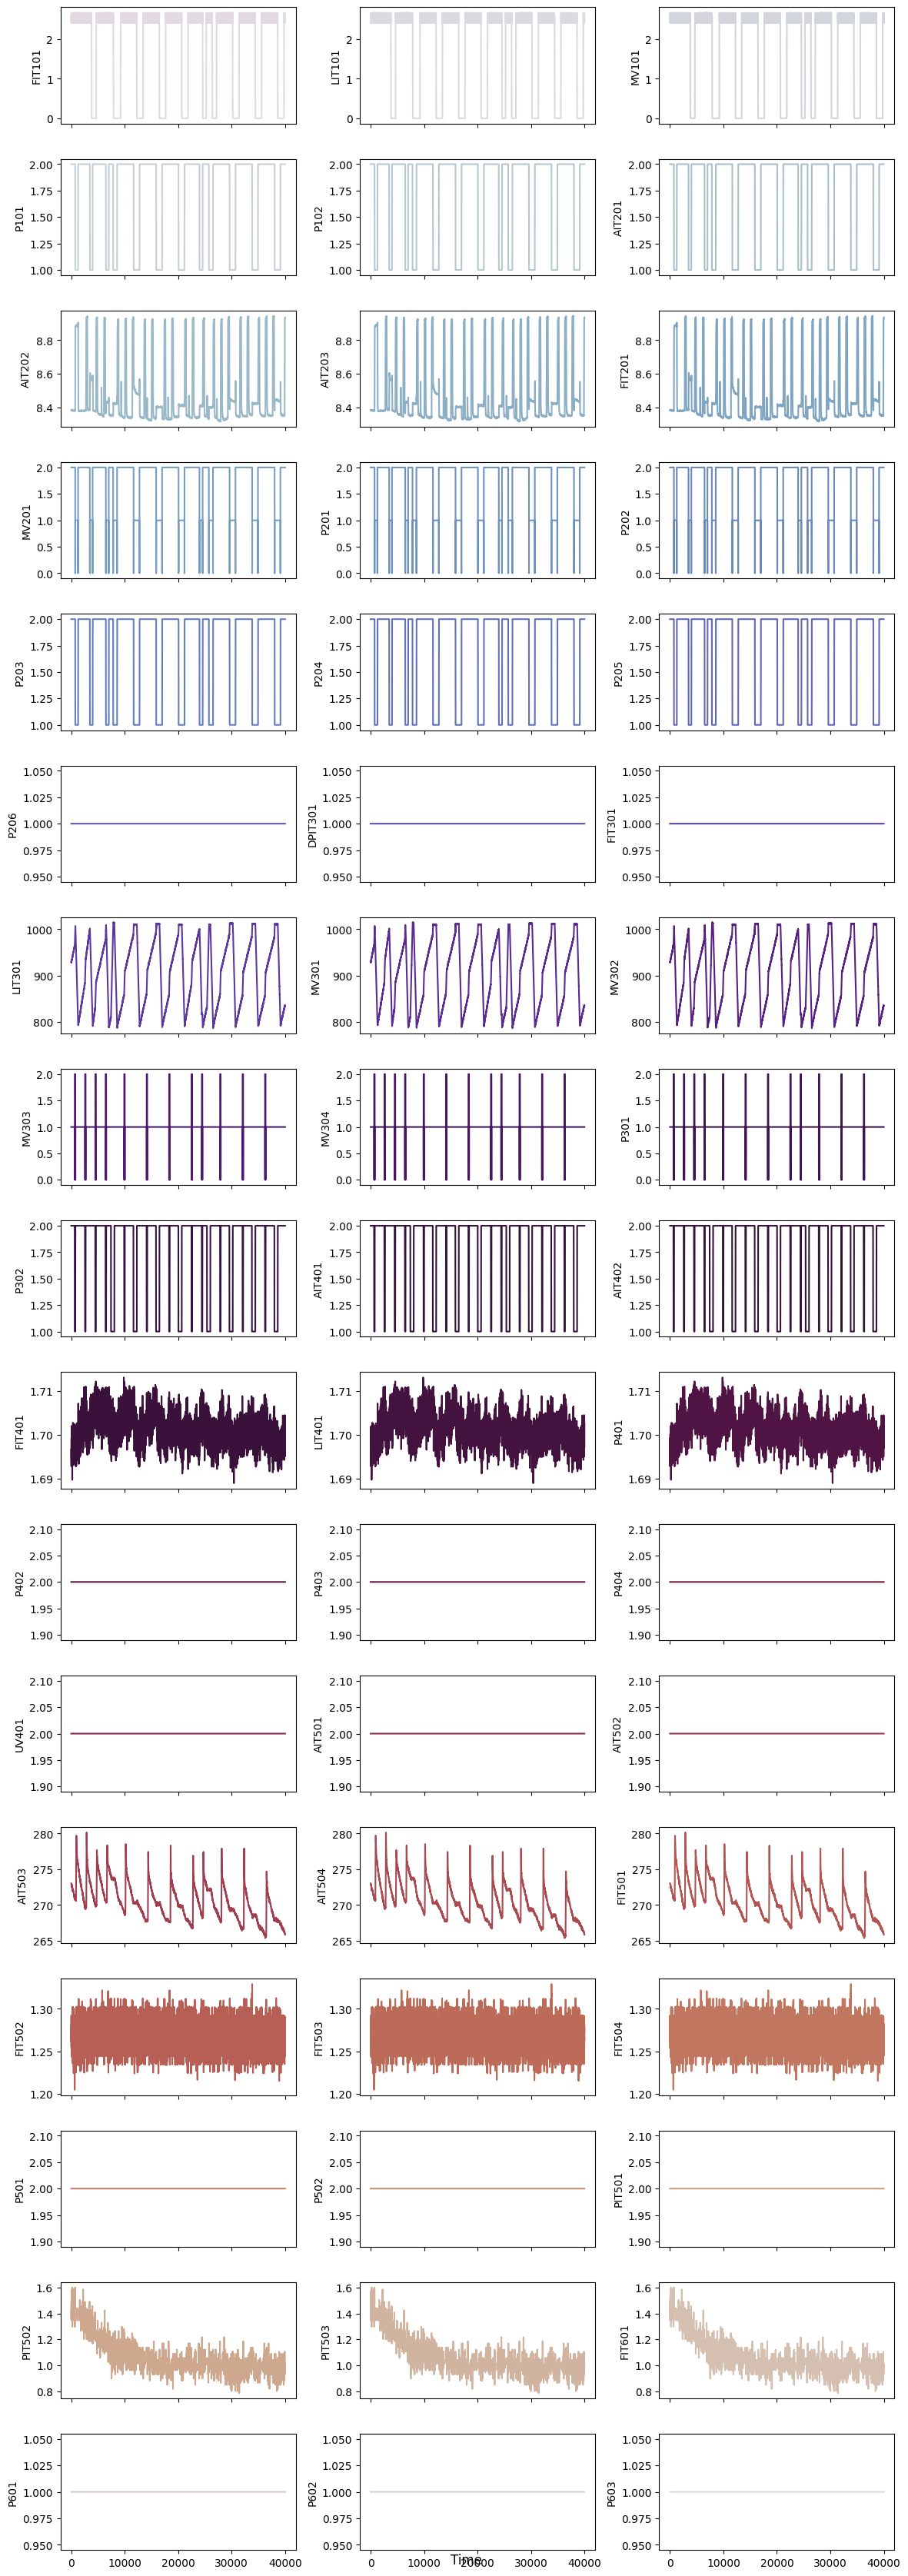

In [40]:
funcs.draw_features(data, data.shape[0])

##### Split data into samples

In [41]:
split_proportion = {'train': 0.7, 'validation': 0.1, 'test': 0.2}

In [42]:
train_data = data.values[:round(split_proportion['train']*data.shape[0]), :]
valid_data = data.values[round(split_proportion['train']*data.shape[0]):round((split_proportion['train']+split_proportion['validation'])*data.shape[0]), :]
test_data = data.values[-round(split_proportion['test']*data.shape[0]):, :]

print(f'Train sample size: {train_data.shape[0]}\nValidation sample size: {valid_data.shape[0]}\nTest sample size: {test_data.shape[0]}')

Train sample size: 28000
Validation sample size: 4000
Test sample size: 8000


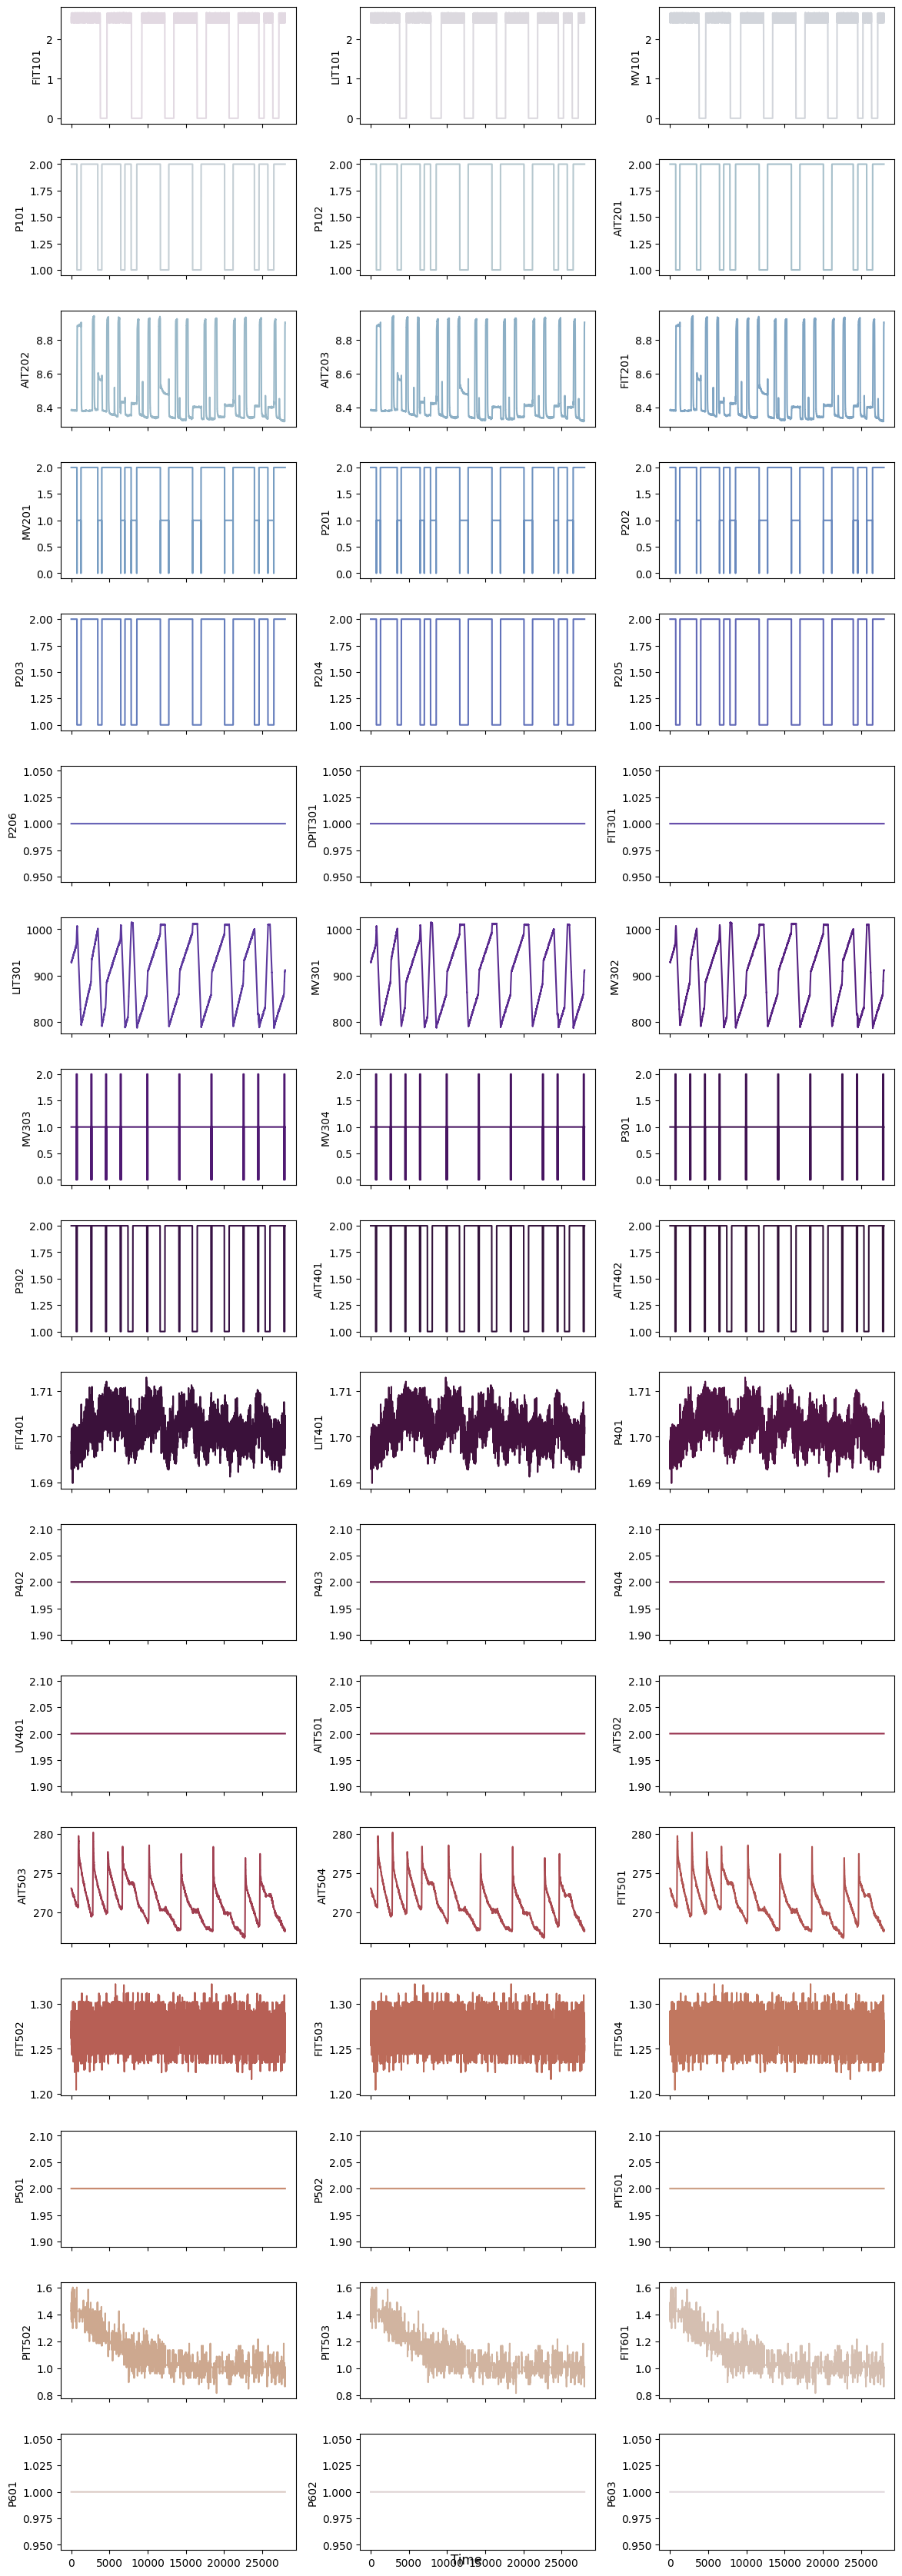

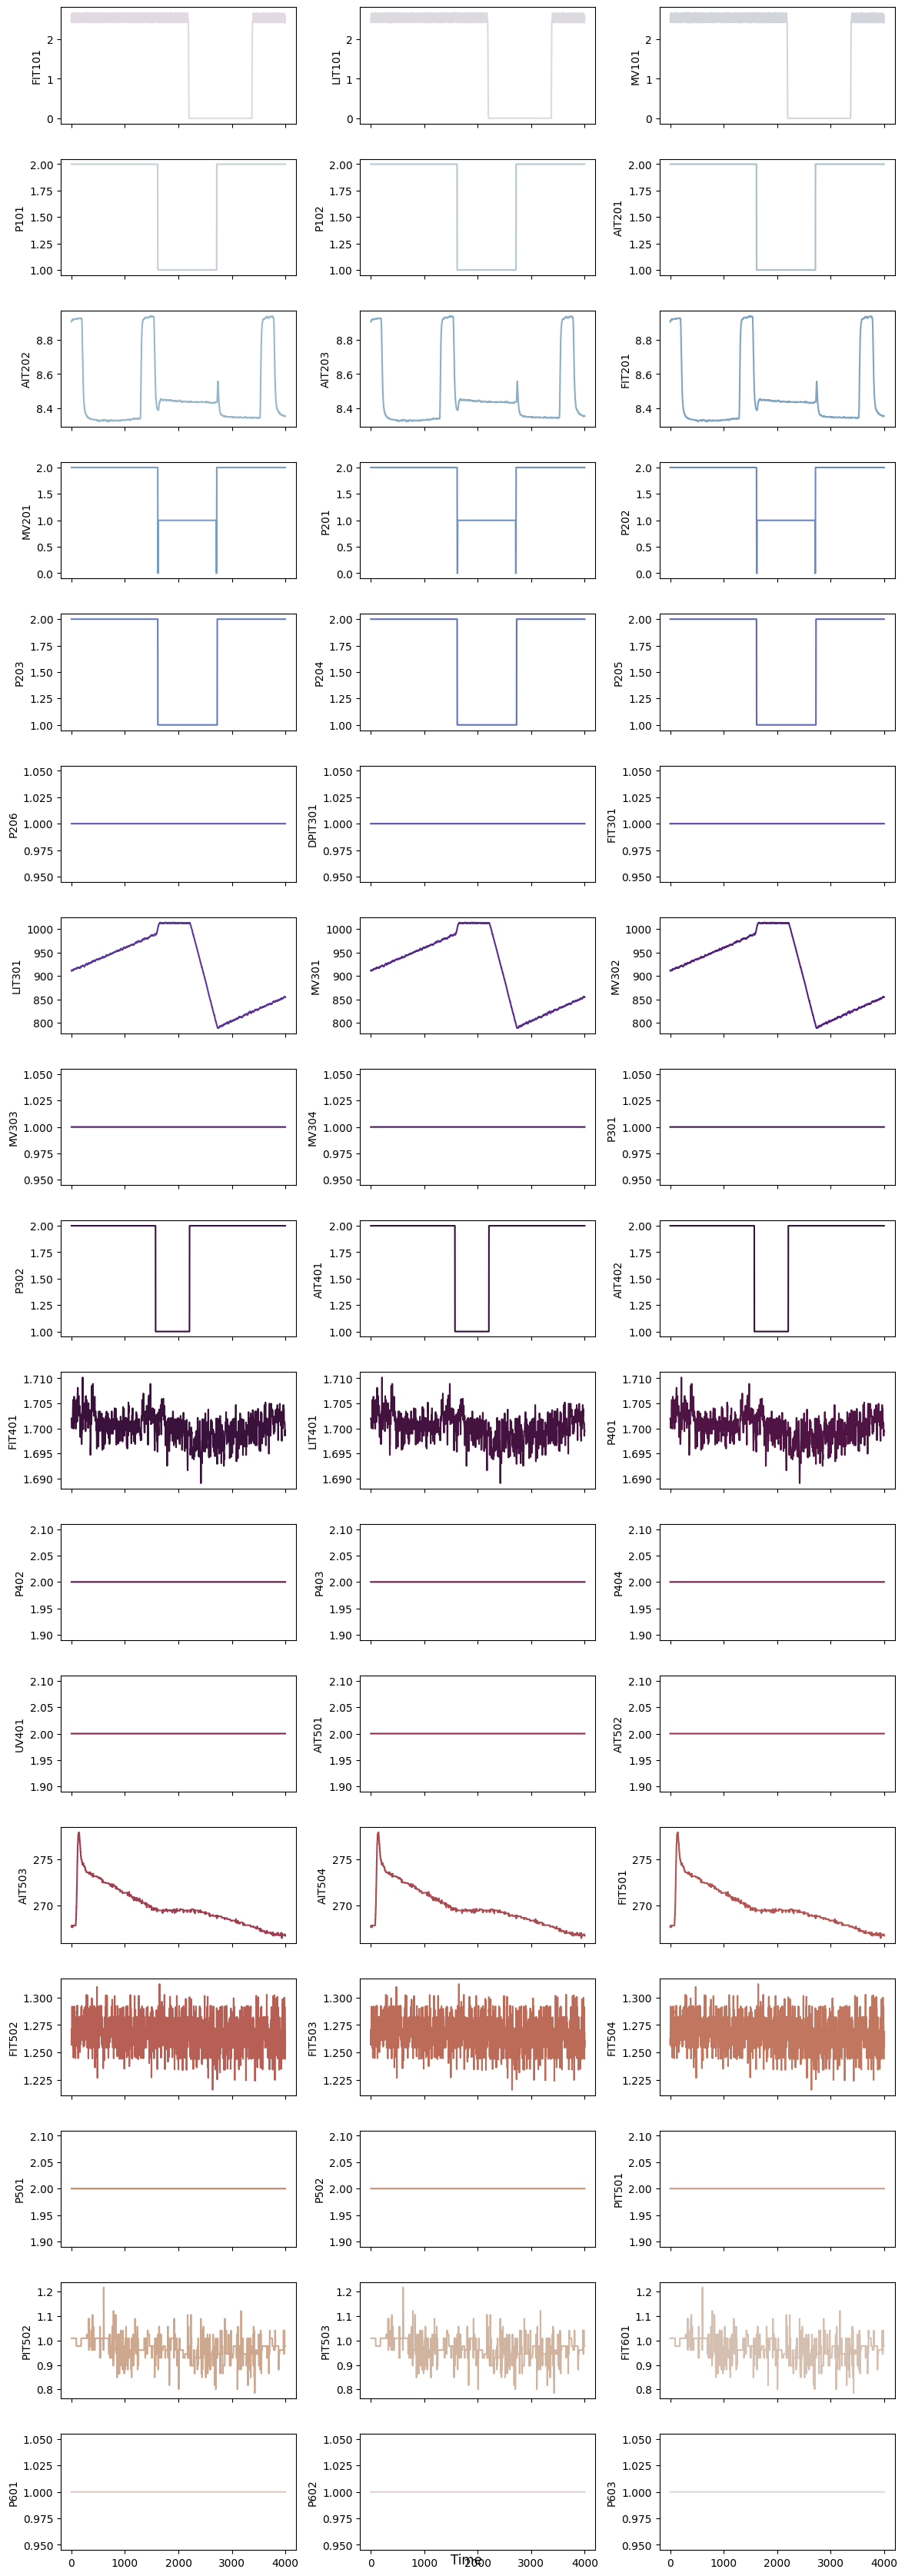

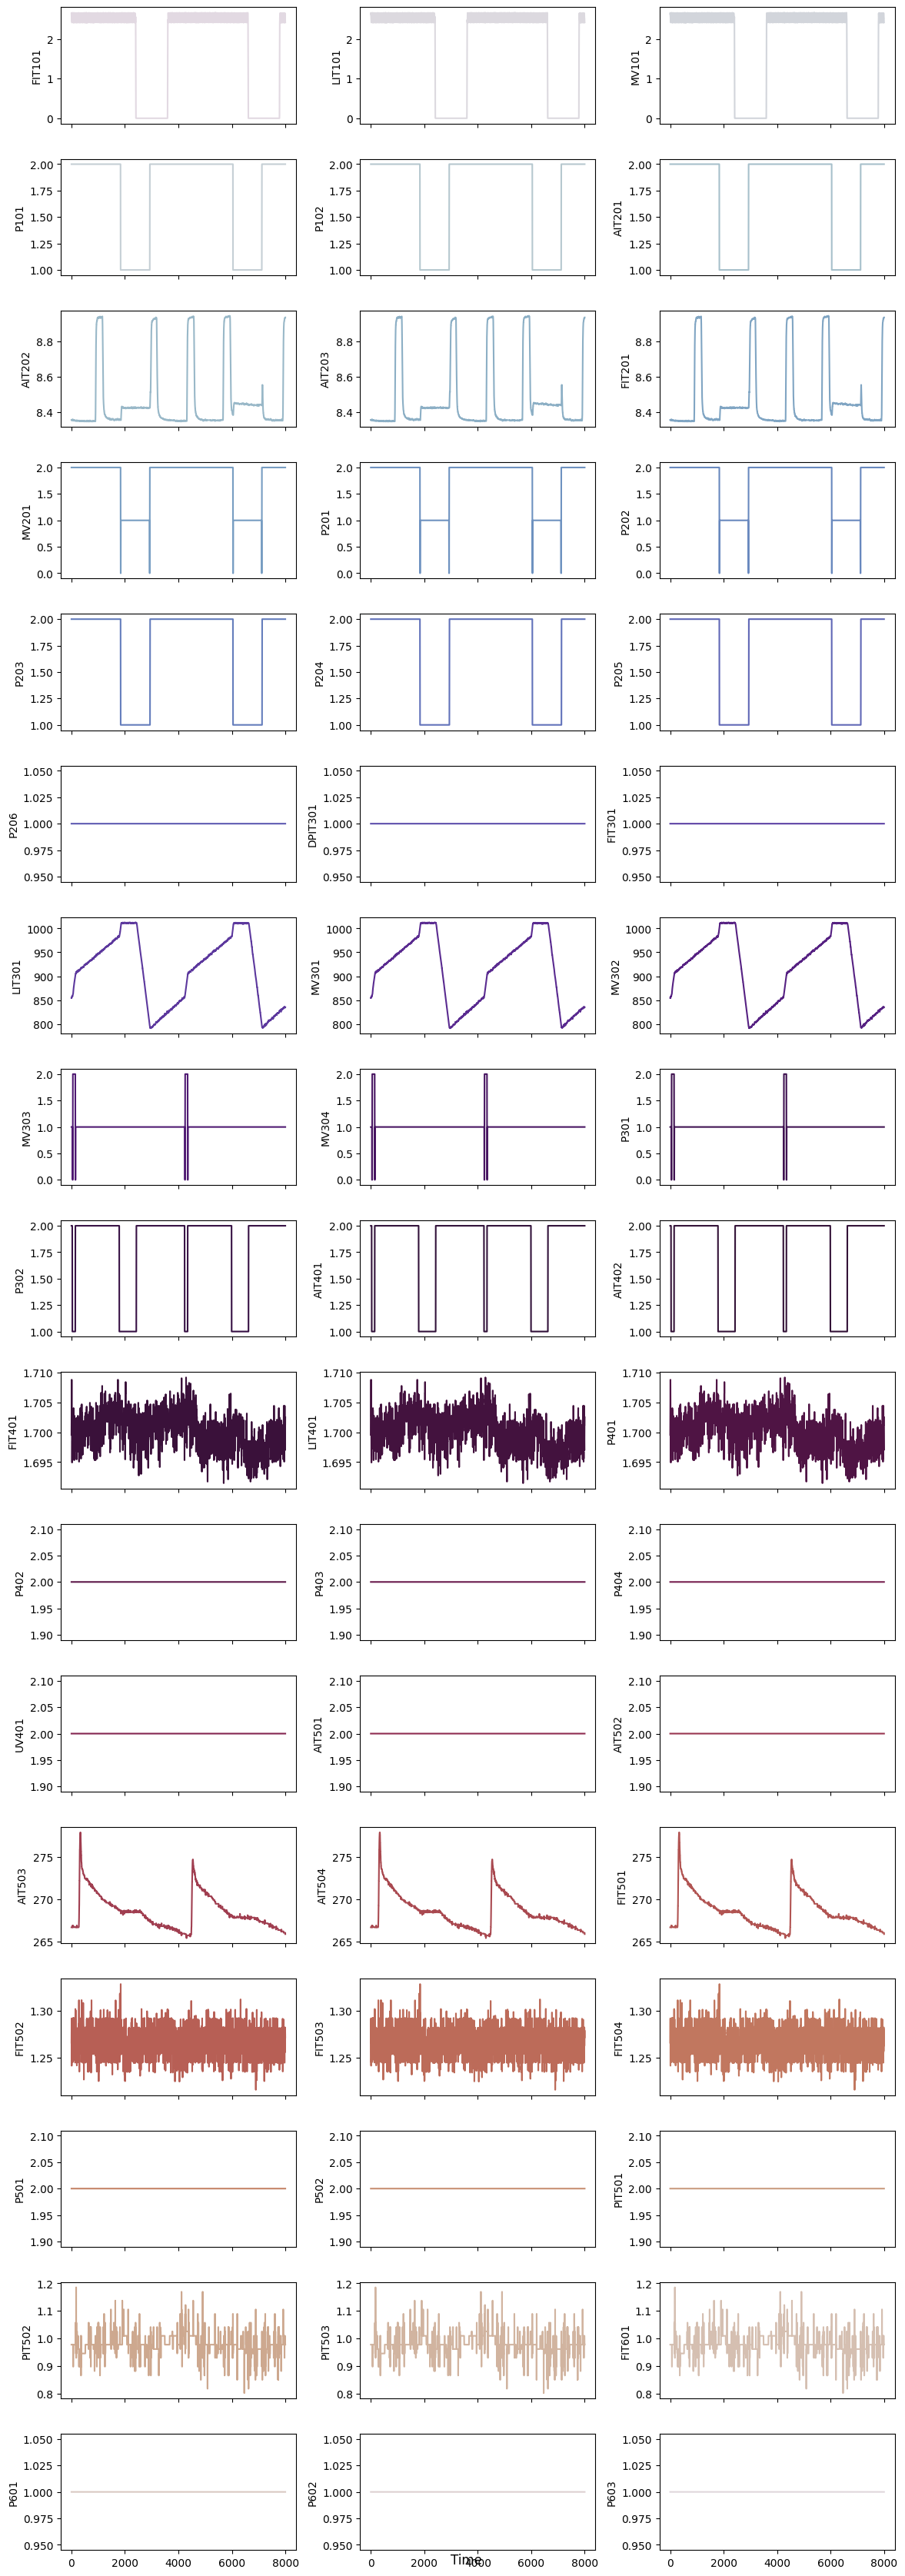

In [22]:
funcs.draw_features(pd.DataFrame(train_data, columns=features_names), train_data.shape[0])
funcs.draw_features(pd.DataFrame(valid_data, columns=features_names), valid_data.shape[0])
funcs.draw_features(pd.DataFrame(test_data, columns=features_names), test_data.shape[0])

##### Normalization

In [43]:
scaler = MinMaxScaler()
scaler.fit(train_data)

MinMaxScaler()

In [44]:
train_data = scaler.transform(train_data)
valid_data = scaler.transform(valid_data)
test_data = scaler.transform(test_data)

#### Create time series generators

In [45]:
look_back_length = 120
horizon = 30
n_features = len(features_names)

model_params = foras.DeepForecasterParameters(n_features=n_features,
                                      look_back_length=look_back_length,
                                      horizon=horizon)

In [46]:
train_ts = foras.TSGenerator(train_data, model_params)
valid_ts = foras.TSGenerator(valid_data, model_params)
test_ts = foras.TSGenerator(test_data, model_params)

print(f'Train timeseries: data shape = {train_ts.data.shape}, targets shape = {train_ts.targets.shape},\n'
      f'Validation timeseries: data shape = {valid_ts.data.shape}, targets shape = {valid_ts.targets.shape},\n'
      f'Test timeseries: data shape = {test_ts.data.shape}, targets shape = {test_ts.targets.shape}\n')

Train timeseries: data shape = (27851, 120, 51), targets shape = (27851, 30, 51),
Validation timeseries: data shape = (3851, 120, 51), targets shape = (3851, 30, 51),
Test timeseries: data shape = (7851, 120, 51), targets shape = (7851, 30, 51)


### Create model and hyperparameters optimization

##### Create tuner for optimization and set search space

In [50]:
tuner = foras.DeepForecasterTuner(model_params)
tuner.set_tuned_hps(block_type=['LSTM', 'GRU'],
                    units=[[512, 256, 128]],
                    dropout=[0.0, 0.01, 0.1],
                    hidden_activation=['tanh', 'relu'],
                    output_activation=['linear', 'sigmoid'])
print(tuner.hp_choices)

{'block_type': ['LSTM', 'GRU'], 'units': {'units_0': [512, 256, 128]}, 'dropout': [0.0, 0.01, 0.1], 'hidden_activation': ['tanh', 'relu'], 'output_activation': ['linear', 'sigmoid']}


##### Search 3 best models with Bayesian optimization algorithm

In [51]:
best_models = tuner.find_best_models(train_ts.get_data(), train_ts.get_targets(),
                                     validation_data=(valid_ts.get_data(), valid_ts.get_targets()), 
                                     tuner_type='BayesianOptimization',
                                     max_trials=5,
                                     epochs=5,
                                     n_models=3,
                                     batch_size=64)

Trial 5 Complete [00h 04m 41s]
val_loss: 0.012122753076255322

Best val_loss So Far: 0.009020061232149601
Total elapsed time: 00h 25m 15s
Results summary
Showing 3 best trials

Trial 0 summary
Hyperparameters:
block_type: GRU
units_0: 128
hidden_activation: tanh
dropout: 0.1
output_activation: sigmoid
Score: 0.009020061232149601

Trial 3 summary
Hyperparameters:
block_type: GRU
units_0: 256
hidden_activation: relu
dropout: 0.1
output_activation: sigmoid
Score: 0.009170601144433022

Trial 2 summary
Hyperparameters:
block_type: GRU
units_0: 128
hidden_activation: relu
dropout: 0.01
output_activation: linear
Score: 0.011152257211506367


##### Save best deep forecasting model configurations

In [52]:
config_directory = 'ai_models/forecastate/configs'

In [53]:
configurations_names = []

if not os.path.exists(config_directory):
    os.makedirs(config_directory)

for i, model in enumerate(best_models):
    filename = f'{config_directory}/{data_name.lower()}_{model.default_name}_{i}.json'
    configurations_names.append(f'{data_name.lower()}_{model.default_name}_{i}.json')
    
    model.save_model_config(filename)
    print(f'Model {i} configuration save to', filename)

Model 0 configuration save to ai_models/forecastate/configs/swat_gru_128_d01_0.json
Model 1 configuration save to ai_models/forecastate/configs/swat_gru_256_d01_1.json
Model 2 configuration save to ai_models/forecastate/configs/swat_gru_128_d001_2.json


### Train deep forecasting models

In [54]:
model_directory = 'ai_models/forecastate/ready'
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
histories = []

In [55]:
configurations_names = [filename for filename in os.listdir(config_directory)]

In [56]:
for i, config in enumerate(configurations_names):
    # Get model from configuration
    model = foras.DeepForecaster(from_file_config=f'{config_directory}/{config}')
    print(model.default_name)
    # Train model
    model.train(train_ts.get_data(), train_ts.get_targets(), 
                validation_data=(valid_ts.get_data(), valid_ts.get_targets()),
                batch_size=64, n_epochs=30, early_stop_patience=5) 
    # Get train history
    histories.append(model.history)
    # Save trained model
    model_filename = f'{model_directory}/{data_name.lower()}_{model.default_name}_{i}.keras'
    model.save_model(model_filename)
    print(f'Model {i} save to', model_filename)
    print()

gru_128_d001
Epoch 1/30
436/436 [==============================] - 63s 142ms/step - loss: 0.0348 - val_loss: 0.0174
Epoch 2/30
436/436 [==============================] - 52s 119ms/step - loss: 0.0158 - val_loss: 0.0158
Epoch 3/30
436/436 [==============================] - 46s 105ms/step - loss: 0.0135 - val_loss: 0.0137
Epoch 4/30
436/436 [==============================] - 46s 106ms/step - loss: 0.0120 - val_loss: 0.0137
Epoch 5/30
436/436 [==============================] - 47s 108ms/step - loss: 0.0112 - val_loss: 0.0140
Epoch 6/30
436/436 [==============================] - 46s 105ms/step - loss: 0.0107 - val_loss: 0.0140
Epoch 7/30
436/436 [==============================] - 46s 105ms/step - loss: 0.0100 - val_loss: 0.0112
Epoch 8/30
436/436 [==============================] - 47s 107ms/step - loss: 0.0103 - val_loss: 0.0162
Epoch 9/30
436/436 [==============================] - 47s 107ms/step - loss: 0.0095 - val_loss: 0.0120
Epoch 10/30
436/436 [==============================] - 53s 1

KeyboardInterrupt: 

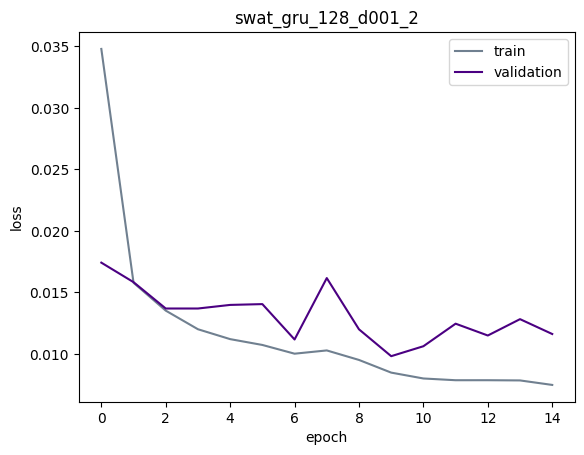

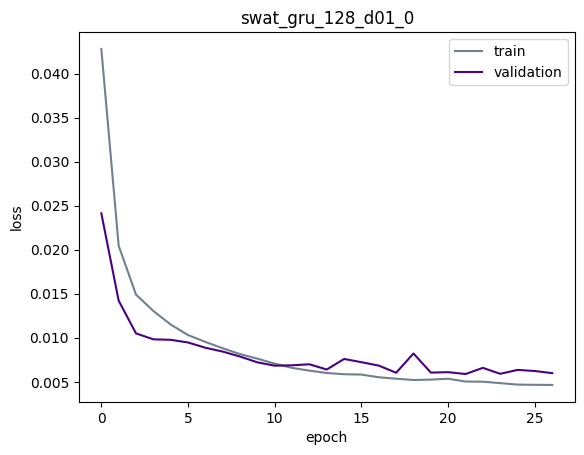

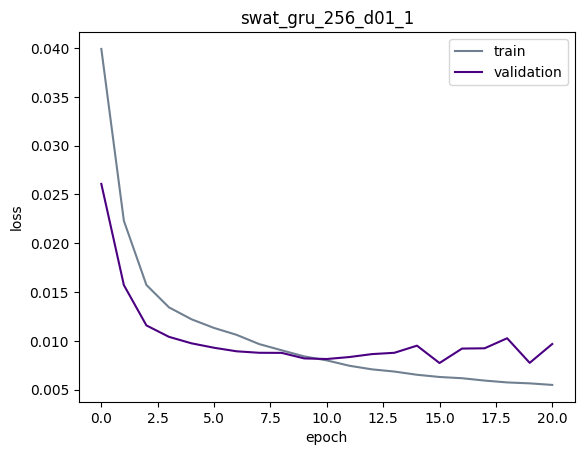

In [57]:
 for config, history in zip(configurations_names, histories):
    plt.plot(history.history['loss'], color='slategrey')
    plt.plot(history.history['val_loss'], color='indigo')
    plt.title(config.replace('.json', ''))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

In [58]:
directory = 'ai_models/forecastate/ready'
best_models = []

for file in os.listdir(directory):
    if data_name.lower() in file:
        print(file)
        model = foras.DeepForecaster(from_file=f'{directory}/{file}')
        best_models.append(model)

swat_gru_128_d001_0.keras
swat_gru_128_d01_1.keras
swat_gru_256_d01_2.keras


### Evaluation

#### Forecasting data length is equal to horizon

In [59]:
forecasting_data_length = horizon
print(f'forecasting_data_length={forecasting_data_length}')

forecasting_data_length=30


In [60]:
current_batch = test_ts.get_data()
print('Data for forecasting:', current_batch.shape)

Data for forecasting: (7851, 120, 51)


##### Create estimator

In [61]:
estimator = foras.ForecastEstimator(features_names=features_names)
estimator.set_true_values(test_ts.get_targets())
estimator.set_first_batch(test_ts.get_data(window_id=0))

##### Deep forecasting

In [62]:
for model_filename in os.listdir(model_directory):
    model = foras.DeepForecaster(from_file=f'{model_directory}/{model_filename}')
    print(model.default_name)
    pred = model.forecasting(current_batch,
           forecasting_data_length=forecasting_data_length)
    estimator.set_pred_values(pred, model_name=model.default_name)

gru_128_d001
786/786 [==============================] - 10s 12ms/step
gru_128_d01
786/786 [==============================] - 10s 13ms/step
gru_256_d01
786/786 [==============================] - 25s 32ms/step


##### Evaluation

In [63]:
estimator.estimate()
estimator.quality

,gru_128_d001_MSE,gru_128_d001_RMSE,gru_128_d001_MAE,gru_128_d001_R2,gru_128_d01_MSE,gru_128_d01_RMSE,gru_128_d01_MAE,gru_128_d01_R2,gru_256_d01_MSE,gru_256_d01_RMSE,gru_256_d01_MAE,gru_256_d01_R2
FIT101,0.022342,0.149472,0.124214,0.882300,0.005473,0.073978,0.036955,0.971169,1.040323e-02,0.101996,0.053452,0.945195
LIT101,0.015394,0.124073,0.096261,0.764718,0.014252,0.119383,0.093632,0.782168,6.399323e-03,0.079996,0.062471,0.902193
MV101,0.012923,0.113680,0.092829,0.766487,0.005736,0.075740,0.046160,0.896345,1.012135e-02,0.100605,0.060956,0.817114
P101,0.030610,0.174956,0.130000,0.847170,0.004938,0.070269,0.016788,0.975347,9.275150e-03,0.096308,0.028432,0.953691
P102,0.002010,0.044828,0.034693,0.000000,0.000010,0.003083,0.002458,0.000000,7.500661e-07,0.000866,0.000739,0.000000
AIT201,0.080182,0.283164,0.274295,-65.741787,0.127109,0.356524,0.355442,-104.803079,1.338130e-01,0.365805,0.364418,-110.382886
AIT202,0.011188,0.105773,0.085367,0.875052,0.003535,0.059458,0.038163,0.960518,2.624111e-03,0.051226,0.032141,0.970694
AIT203,0.027163,0.164812,0.130821,0.173998,0.015067,0.122746,0.098524,0.541841,2.786673e-02,0.166933,0.128572,0.152603
FIT201,0.028468,0.168724,0.124978,0.852407,0.002873,0.053602,0.015396,0.985104,5.349140e-03,0.073138,0.029005,0.972267
MV201,0.014189,0.119119,0.092673,0.728139,0.004804,0.069310,0.039616,0.907960,2.263683e-02,0.150455,0.074959,0.566289


c:\program files (x86)\python\python38\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


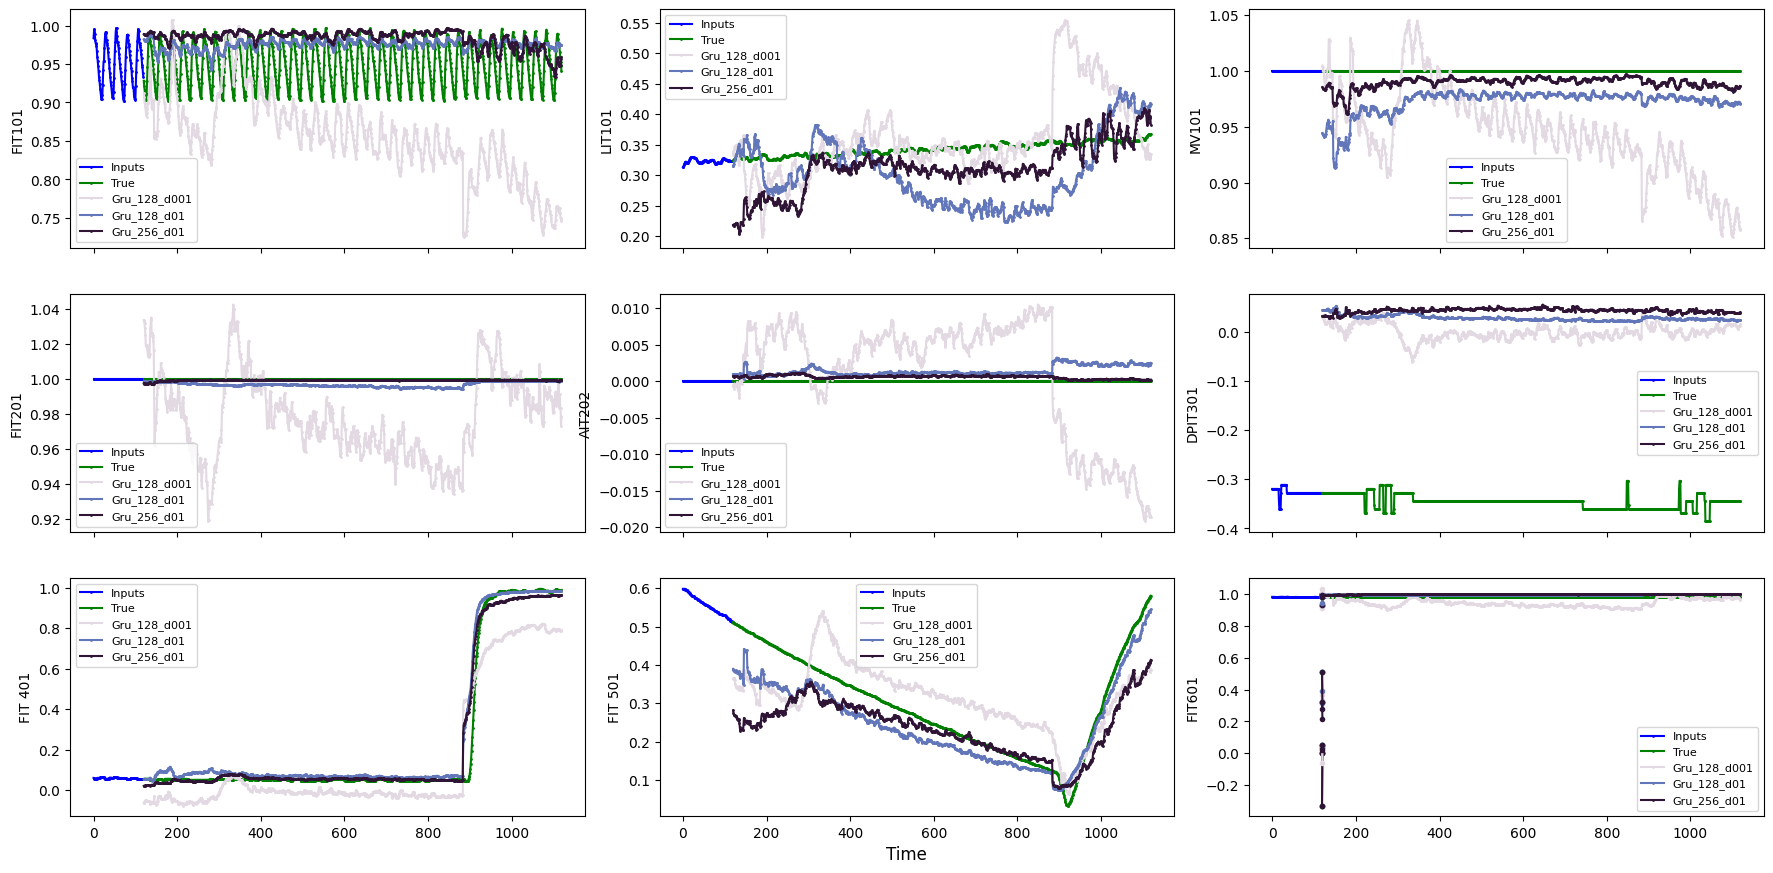

In [69]:
estimator.draw(features_names=['FIT101', 'LIT101', 'MV101', 'FIT201', 'AIT202', 
                               'DPIT301', 'FIT 401', 'FIT 501', 'FIT601'],
               size=1000)